In [1]:
import pandas as pd

In [2]:
representative_molecules = pd.read_csv('Oxime.csv')

In [3]:
from rdkit import Chem
import pandas as pd

# Function to canonicalize SMILES
def canonicalize_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
    except Exception as e:
        print(f"Error in canonicalizing SMILES: {smiles}, Error: {e}")
    return None

# Canonicalize SMILES in representative_molecules dataframe
representative_molecules['canonical_smiles'] = representative_molecules['SMILES'].apply(canonicalize_smiles)


In [4]:
representative_molecules.head()

,SMILES,canonical_smiles
0,O=NC1=CC=C(N=O)C=C1,O=Nc1ccc(N=O)cc1
1,O/N=C1C=C/C(C=C/1)=N\O,ON=C1C=CC(=NO)C=C1
2,O=N/C(C1=CC=CC=C1)=C(N=O)/C2=CC=CC=C2,O=N/C(=C(\N=O)c1ccccc1)c1ccccc1
3,O=N1=C(C(C2=CC=CC=C2)=NO1)C3=CC=CC=C3,[O-][n+]1onc(-c2ccccc2)c1-c1ccccc1
4,O/N=C(C1=CC=CC=C1)/C(C2=CC=CC=C2)=N/O,O/N=C(C(=N/O)/c1ccccc1)\c1ccccc1


#### Pretrained model

In [5]:
import torch
from transformers import AutoTokenizer, AutoModel

# Load the ChemBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1", clean_up_tokenization_spaces=False)
model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# Ensure the model is in evaluation mode
model.eval()

# Function to compute embeddings
def get_chemberta_embeddings(smiles_series):
    embeddings = []
    
    for smiles in smiles_series:
        # Tokenize the SMILES string
        inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True, max_length=512)
        
        # Forward pass through the model to get hidden states
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
        
        # Extract the last hidden state (embedding for each token)
        hidden_states = outputs.hidden_states[-1]
        
        # Average the embeddings for all tokens (this creates a single vector for the molecule)
        molecule_embedding = hidden_states.mean(dim=1).squeeze()
        
        # Convert to numpy array (or keep as tensor if preferred)
        embeddings.append(molecule_embedding.cpu().numpy())
    
    return embeddings


In [6]:
# Get embeddings for the representative molecules
rep_embeddings = get_chemberta_embeddings(representative_molecules['canonical_smiles'])

# Add embeddings to the dataframes for future use
representative_molecules['embedding'] = rep_embeddings

In [7]:
# Save the embeddings as .csv files
representative_molecules.to_csv('representative_Oxime_embeddings.csv', index=False)

#### Similarity search

In [ ]:
representative_molecules= pd.read_csv('representative_Oxime_embeddings.csv')


In [9]:
zinc_data= pd.read_csv('zinc_data100-149_embeddings.csv')

In [10]:
representative_molecules.head()

,SMILES,canonical_smiles,embedding
0,O=NC1=CC=C(N=O)C=C1,O=Nc1ccc(N=O)cc1,"[0.13897163, 0.4943188, 0.48055726, -1.0952749..."
1,O/N=C1C=C/C(C=C/1)=N\O,ON=C1C=CC(=NO)C=C1,"[0.37254566, 0.39315847, 0.11318481, -0.546145..."
2,O=N/C(C1=CC=CC=C1)=C(N=O)/C2=CC=CC=C2,O=N/C(=C(\N=O)c1ccccc1)c1ccccc1,"[0.2048742, 0.9607414, 0.16716672, 0.16178407,..."
3,O=N1=C(C(C2=CC=CC=C2)=NO1)C3=CC=CC=C3,[O-][n+]1onc(-c2ccccc2)c1-c1ccccc1,"[0.18520527, 0.4574728, 0.12148504, -0.1520772..."
4,O/N=C(C1=CC=CC=C1)/C(C2=CC=CC=C2)=N/O,O/N=C(C(=N/O)/c1ccccc1)\c1ccccc1,"[0.074393354, 0.8041717, 0.16998796, -0.062742..."


In [11]:
zinc_data.head()

,smiles,zinc_id,sanitized_smiles,embedding
0,OC[C@@H]1CCCNC1,388342,OC[C@@H]1CCCNC1,[ 0.9666779 1.5613511 0.5307051 -1.689823...
1,C[C@@H](O)C(CO)[C@@H](C)O,410291,C[C@@H](O)C(CO)[C@@H](C)O,[ 8.85525942e-01 4.75031137e-01 8.14026058e-...
2,NCC1(O)CC1,2540025,NCC1(O)CC1,[ 1.42514658e+00 5.75718105e-01 -9.27593186e-...
3,CN1CCN=C1N,3075393,CN1CCN=C1N,[ 5.56800425e-01 4.72808301e-01 3.14810008e-...
4,O=Cc1cn(CC(=O)O)cn1,59724508,O=Cc1cn(CC(=O)O)cn1,[-3.00049424e-01 2.83116996e-01 8.10068250e-...


In [12]:
import pandas as pd
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import re  # Regular expressions for cleaning strings

# Function to clean and convert embedding strings to tensors
def convert_to_tensor(embedding):
    if isinstance(embedding, str):
        # Remove brackets and newlines, split by spaces to get list of floats
        cleaned_embedding = re.sub(r'[\[\]\n]', '', embedding).strip()  # Remove brackets and newlines
        embedding_list = list(map(float, cleaned_embedding.split()))  # Convert to list of floats
        return torch.tensor(embedding_list)
    return torch.tensor(embedding)

# Function to calculate cosine similarity between two sets of embeddings
def calculate_chemberta_similarity(rep_embeddings, zinc_embeddings, threshold, zinc_data):
    results = []
    seen_zinc_ids = set()  # To track already matched ZINC molecules
    
    # Convert lists of embeddings to tensors
    rep_embeddings = [convert_to_tensor(embedding) for embedding in rep_embeddings]
    zinc_embeddings = [convert_to_tensor(embedding) for embedding in zinc_embeddings]

    # Stack tensors and convert to numpy arrays for similarity calculation
    rep_embeddings = torch.stack(rep_embeddings).detach().numpy()
    zinc_embeddings = torch.stack(zinc_embeddings).detach().numpy()

    # Calculate cosine similarity between representative and zinc molecule embeddings
    similarity_matrix = cosine_similarity(rep_embeddings, zinc_embeddings)
    
    # Loop over similarity scores and filter based on the threshold
    for rep_idx, similarities in enumerate(similarity_matrix):
        for zinc_idx, similarity in enumerate(similarities):
            zinc_id = zinc_data.iloc[zinc_idx]['zinc_id']  # Access zinc_id safely
            if zinc_id in seen_zinc_ids:
                continue  # Skip if we have already seen this ZINC ID
            
            if similarity >= threshold:
                results.append({
                    'sanitized_smiles': zinc_data.iloc[zinc_idx]['sanitized_smiles'],
                    'zinc_id': zinc_id,
                    'similarity': similarity  # Store the similarity score
                })
                seen_zinc_ids.add(zinc_id)  # Mark this ZINC ID as seen
    
    return results

# Example usage
similarity_threshold = 0.3

# Ensure that you have 'embedding' columns in both dataframes
rep_embeddings = representative_molecules['embedding'].tolist()
zinc_embeddings = zinc_data['embedding'].tolist()

# Perform the similarity search using ChemBERTa embeddings
results = calculate_chemberta_similarity(rep_embeddings, zinc_embeddings, similarity_threshold, zinc_data)

# Convert the result to DataFrame and save to CSV, including similarity scores
results_df = pd.DataFrame(results)
results_df.to_csv('similar_molecules_Oxime_chemberta.csv', index=False)

print("Similarity search completed, and results (including similarity scores) saved to similar_molecules_chemberta.csv")


KeyboardInterrupt: 

Key Changes:
Removed torch usage: Now, everything is handled using numpy arrays instead of converting them to torch tensors.
Cosine similarity with numpy: The function cosine_similarity from sklearn works perfectly with numpy arrays, so there is no need to convert them into torch tensors.

In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import re  # Regular expressions for cleaning strings

# Function to clean and convert embedding strings to numpy arrays (instead of tensors)
def convert_to_numpy_array(embedding):
    if isinstance(embedding, str):
        cleaned_embedding = re.sub(r'[\[\]\n]', '', embedding).strip()  # Remove brackets and newlines
        embedding_list = list(map(float, cleaned_embedding.split()))  # Convert to list of floats
        return np.array(embedding_list)
    return np.array(embedding)

# Function to calculate cosine similarity between two sets of embeddings
def calculate_chemberta_similarity(rep_embeddings, zinc_embeddings, threshold, zinc_data):
    results = []
    seen_zinc_ids = set()  # To track already matched ZINC molecules
    
    # Convert lists of embeddings to numpy arrays
    rep_embeddings = [convert_to_numpy_array(embedding) for embedding in rep_embeddings]
    zinc_embeddings = [convert_to_numpy_array(embedding) for embedding in zinc_embeddings]

    # Calculate cosine similarity between representative and zinc molecule embeddings
    similarity_matrix = cosine_similarity(rep_embeddings, zinc_embeddings)
    
    # Loop over similarity scores and filter based on the threshold
    for rep_idx, similarities in enumerate(similarity_matrix):
        for zinc_idx, similarity in enumerate(similarities):
            zinc_id = zinc_data.iloc[zinc_idx]['zinc_id']  # Access zinc_id safely
            if zinc_id in seen_zinc_ids:
                continue  # Skip if we have already seen this ZINC ID
            
            if similarity >= threshold:
                results.append({
                    'sanitized_smiles': zinc_data.iloc[zinc_idx]['sanitized_smiles'],
                    'zinc_id': zinc_id,
                    'similarity': similarity  # Store the similarity score
                })
                seen_zinc_ids.add(zinc_id)  # Mark this ZINC ID as seen
    
    return results

# Example usage
similarity_threshold = 0.3

# Ensure that you have 'embedding' columns in both dataframes
rep_embeddings = representative_molecules['embedding'].tolist()
zinc_embeddings = zinc_data['embedding'].tolist()

# Perform the similarity search using ChemBERTa embeddings
results = calculate_chemberta_similarity(rep_embeddings, zinc_embeddings, similarity_threshold, zinc_data)

# Convert the result to DataFrame and save to CSV, including similarity scores
results_df = pd.DataFrame(results)
results_df.to_csv('similar_molecules_Oxime_chemberta.csv', index=False)

print("Similarity search completed, and results (including similarity scores) saved to similar_molecules_chemberta.csv")

MemoryError: Unable to allocate 5.23 GiB for an array with shape (914733, 768) and data type float64

Key Changes:
Batch Processing: The calculate_chemberta_similarity_in_batches function processes the zinc_embeddings in smaller batches, reducing memory consumption.
Looping in Batches: The code splits the zinc_embeddings into chunks of size batch_size, which can be adjusted based on your available memory.
Cosine Similarity Calculation: The cosine_similarity function is applied to each batch of embeddings rather than all at once.

In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import re  # Regular expressions for cleaning strings

# Function to clean and convert embedding strings to numpy arrays (instead of tensors)
def convert_to_numpy_array(embedding):
    if isinstance(embedding, str):
        cleaned_embedding = re.sub(r'[\[\]\n]', '', embedding).strip()  # Remove brackets and newlines
        embedding_list = list(map(float, cleaned_embedding.split()))  # Convert to list of floats
        return np.array(embedding_list)
    return np.array(embedding)

# Function to calculate cosine similarity in batches
def calculate_chemberta_similarity_in_batches(rep_embeddings, zinc_embeddings, threshold, zinc_data, batch_size=1000):
    results = []
    seen_zinc_ids = set()  # To track already matched ZINC molecules
    
    # Convert representative embeddings to numpy arrays
    rep_embeddings = [convert_to_numpy_array(embedding) for embedding in rep_embeddings]
    
    # Loop over the zinc embeddings in batches
    for start_idx in range(0, len(zinc_embeddings), batch_size):
        end_idx = start_idx + batch_size
        batch_zinc_embeddings = [convert_to_numpy_array(embedding) for embedding in zinc_embeddings[start_idx:end_idx]]
        batch_zinc_data = zinc_data.iloc[start_idx:end_idx]
        
        # Calculate cosine similarity for the current batch
        similarity_matrix = cosine_similarity(rep_embeddings, batch_zinc_embeddings)
        
        # Loop over similarity scores and filter based on the threshold
        for rep_idx, similarities in enumerate(similarity_matrix):
            for zinc_idx, similarity in enumerate(similarities):
                zinc_id = batch_zinc_data.iloc[zinc_idx]['zinc_id']  # Access zinc_id safely
                if zinc_id in seen_zinc_ids:
                    continue  # Skip if we have already seen this ZINC ID
                
                if similarity >= threshold:
                    results.append({
                        'sanitized_smiles': batch_zinc_data.iloc[zinc_idx]['sanitized_smiles'],
                        'zinc_id': zinc_id,
                        'similarity': similarity  # Store the similarity score
                    })
                    seen_zinc_ids.add(zinc_id)  # Mark this ZINC ID as seen
    
    return results

# Example usage
similarity_threshold = 0.3
batch_size = 100000  # Adjust this based on memory constraints

# Ensure that you have 'embedding' columns in both dataframes
rep_embeddings = representative_molecules['embedding'].tolist()
zinc_embeddings = zinc_data['embedding'].tolist()

# Perform the similarity search using ChemBERTa embeddings in batches
results = calculate_chemberta_similarity_in_batches(rep_embeddings, zinc_embeddings, similarity_threshold, zinc_data, batch_size)

# Convert the result to DataFrame and save to CSV, including similarity scores
results_df = pd.DataFrame(results)
results_df.to_csv('similar_molecules_Oxime_chemberta.csv', index=False)

print("Similarity search completed and results (including similarity scores) saved to 'similar_molecules_Oxime_chemberta.csv'")


Similarity search completed and results (including similarity scores) saved to 'similar_molecules_Oxime_chemberta.csv'


In [14]:
import pandas as pd
results_df = pd.read_csv('similar_molecules_Oxime_chemberta.csv')

In [15]:
results_df.head()

,sanitized_smiles,zinc_id,similarity
0,OC[C@@H]1CCCNC1,388342,0.312000
1,C[C@@H](O)C(CO)[C@@H](C)O,410291,0.384272
2,NCC1(O)CC1,2540025,0.368381
3,CN1CCN=C1N,3075393,0.613710
4,O=Cc1cn(CC(=O)O)cn1,59724508,0.627681


In [16]:
results_df.shape

(1086825, 3)

In [17]:
duplicates = results_df.duplicated()
print(duplicates.any())  # This will return True if there are duplicates, False otherwise

False


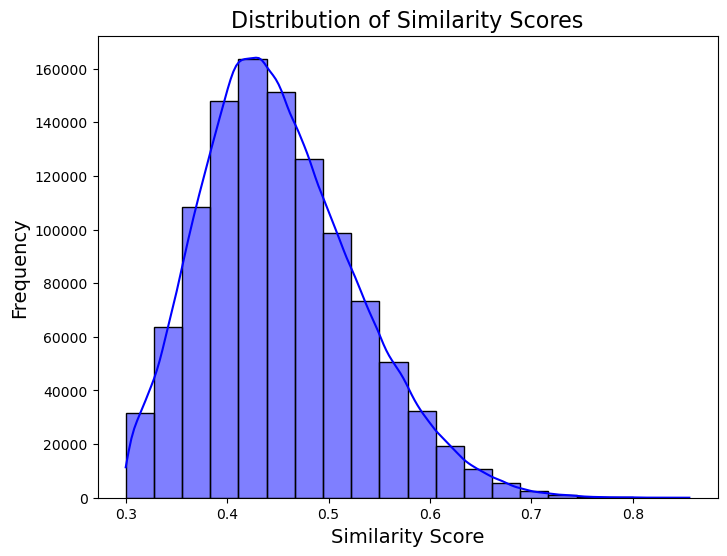

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the similarity scores from the DataFrame
similarity_scores = results_df['similarity']

# Set the plot size
plt.figure(figsize=(8, 6))

# Use seaborn to create a histogram of the similarity scores
sns.histplot(similarity_scores, bins=20, kde=True, color='blue')

# Add labels and title
plt.title('Distribution of Similarity Scores', fontsize=16)
plt.xlabel('Similarity Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()


In [19]:
# Filter the DataFrame for similarity scores >= 0.8
results_df08 = results_df[results_df['similarity'] >= 0.8]

In [20]:
results_df08.shape

(60, 3)

In [23]:
# Filter the DataFrame for similarity scores >= 0.76
results_df076 = results_df[results_df['similarity'] >= 0.76]

In [24]:
results_df076.shape

(306, 3)

In [25]:
from rdkit.Chem import Draw
# Set the maximum number of molecules to display
Draw.IPythonConsole.maxMols = 400  # or any other number you want

In [26]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
from IPython.display import display

# Function to visualize SMILES strings in batches with zinc_id labels
def show_all_molecule_structures(df, batch_size=100, mols_per_row=3):
    # Get all SMILES strings and zinc_ids in the dataframe
    smiles_list = df['sanitized_smiles'].tolist()
    zinc_ids = df['zinc_id'].tolist()

    # Convert SMILES strings to RDKit Mol objects
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

    # Process the molecules in batches to avoid overloading
    for i in range(0, len(mols), batch_size):
        mol_batch = mols[i:i + batch_size]  # Select a batch of molecules
        labels_batch = [f'ZINC ID: {zinc_ids[j]}' for j in range(i, i + len(mol_batch))]  # Select the corresponding labels

        # Display the molecules in a grid with labels
        img = Draw.MolsToGridImage(mol_batch, molsPerRow=mols_per_row, subImgSize=(300, 300), legends=labels_batch)
        display(img)


c:\Users\xueli\miniconda3\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


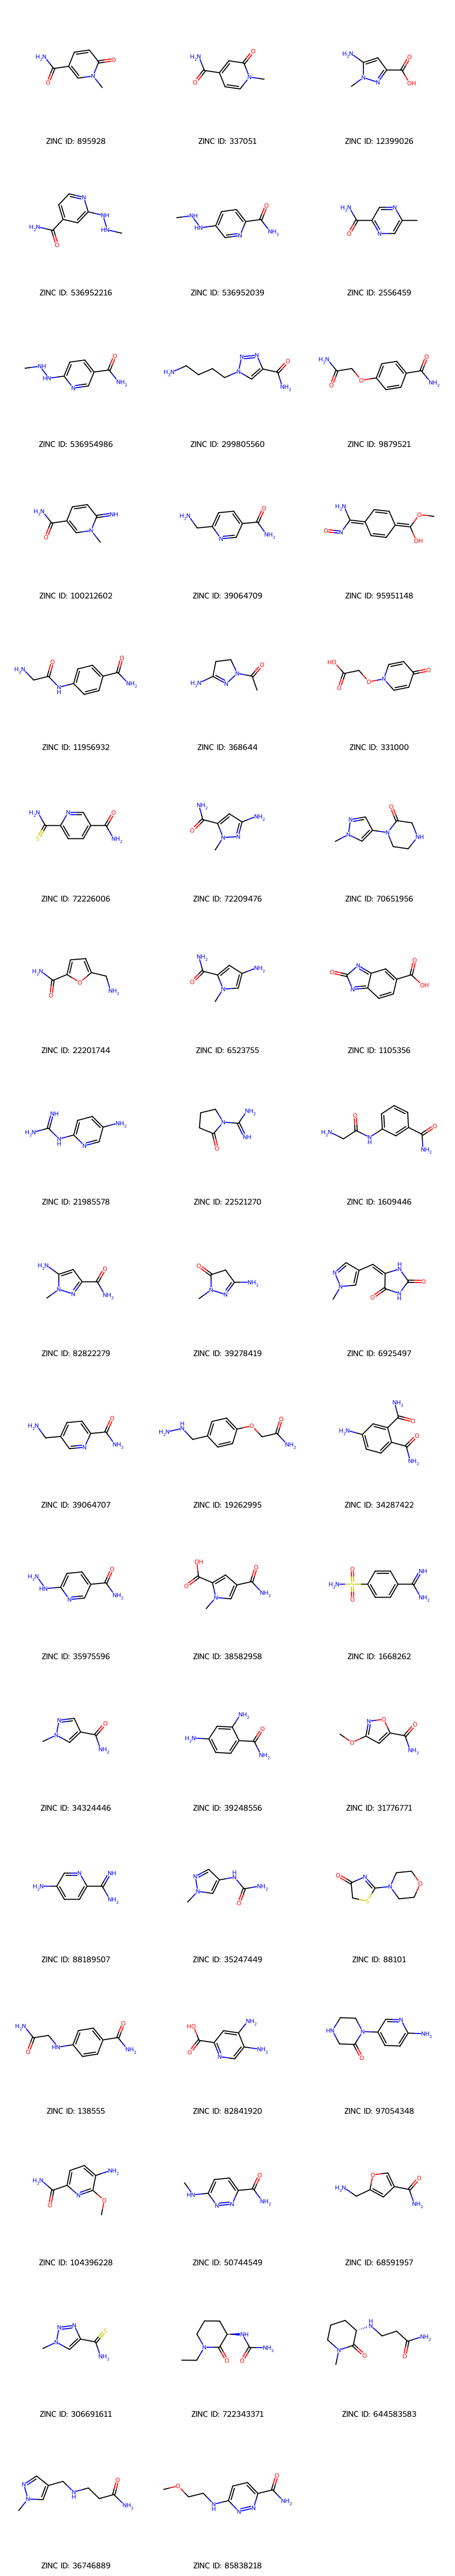

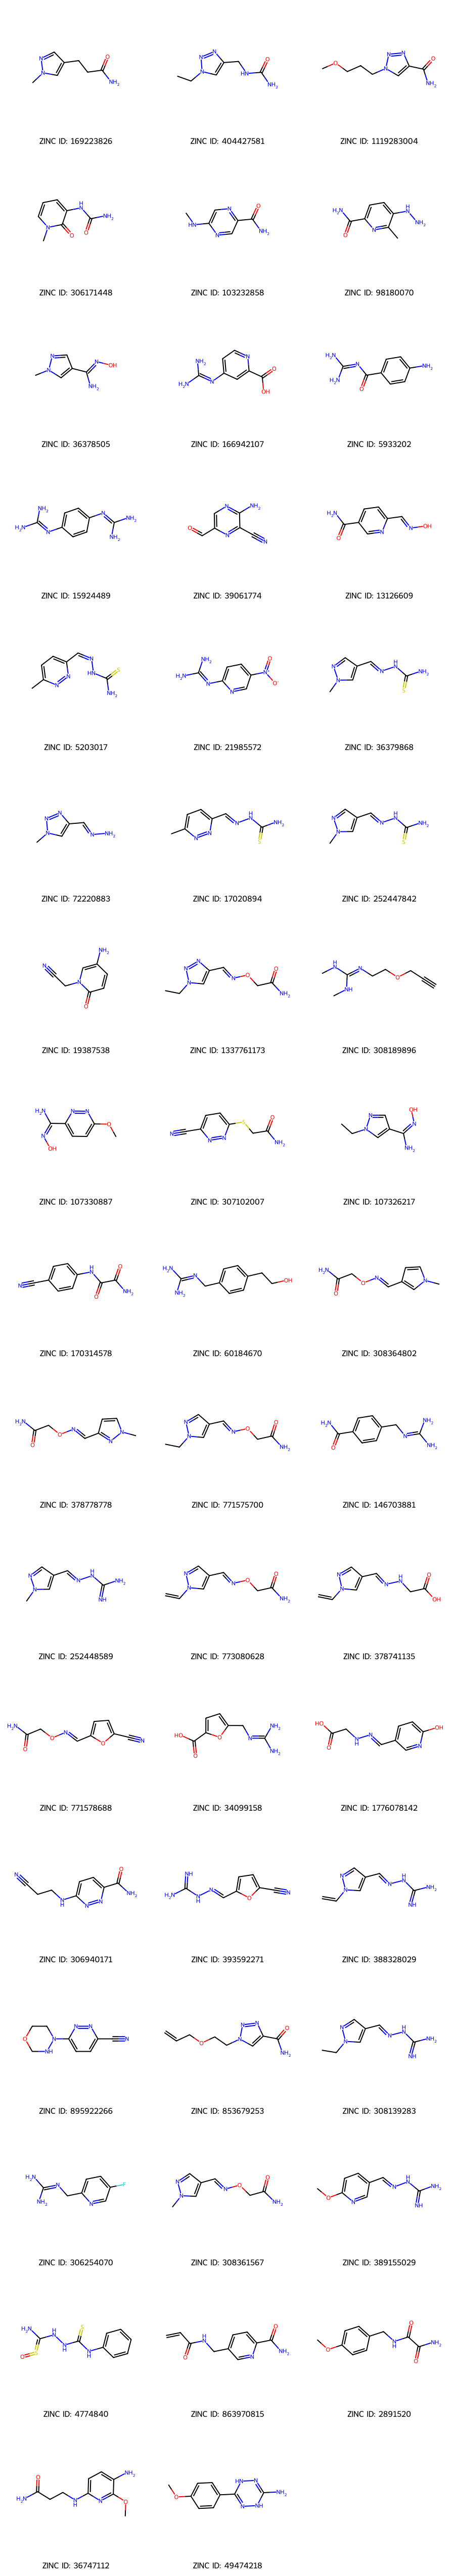

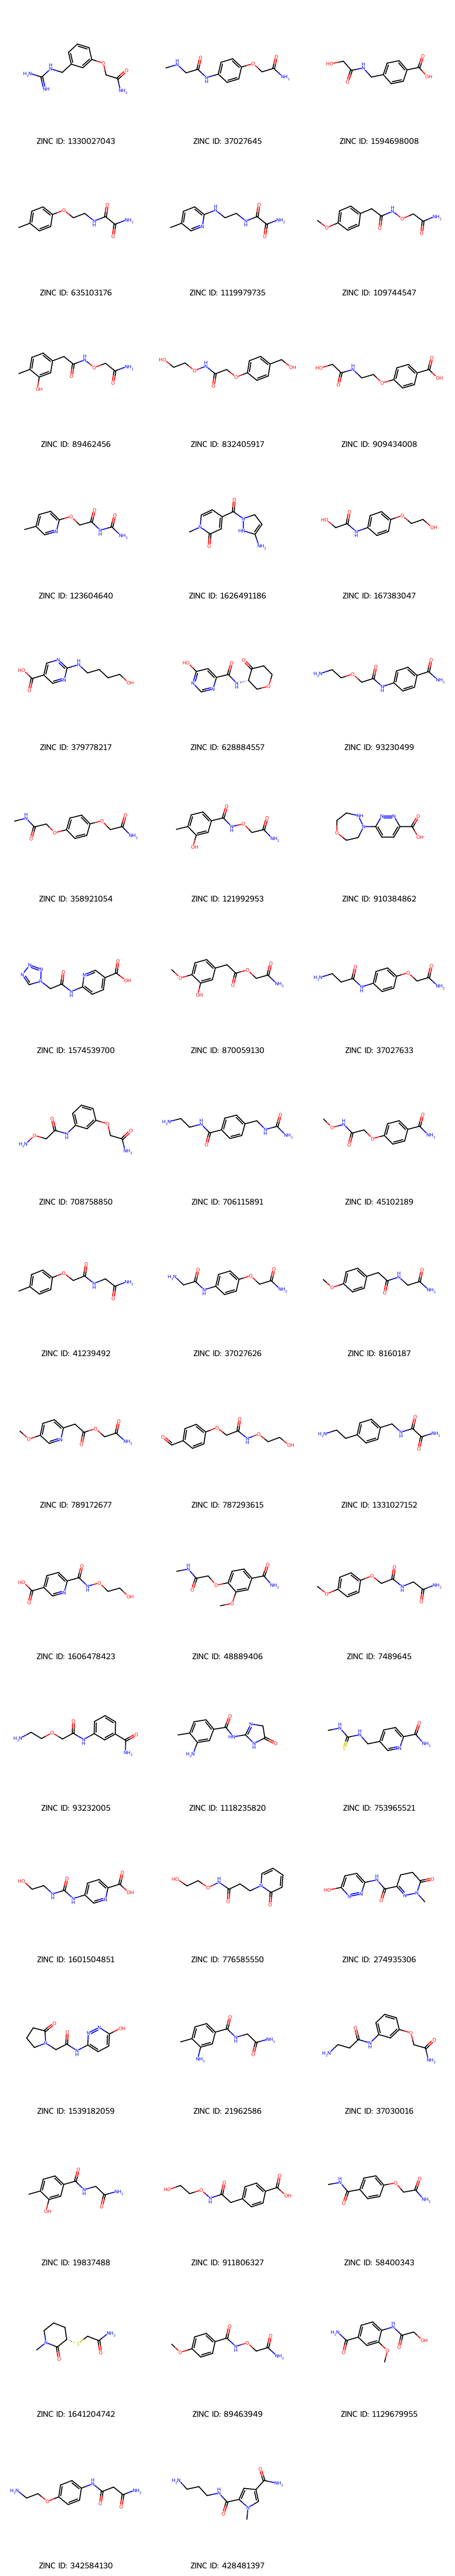

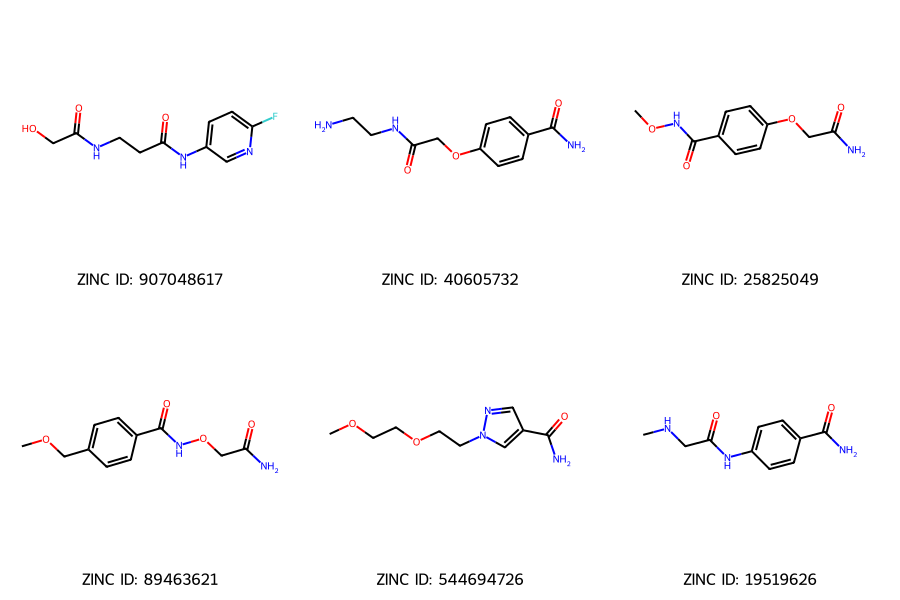

In [27]:
show_all_molecule_structures(results_df076, batch_size=100, mols_per_row=3)